In [1]:
%pip install -r requirements.txt &> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
RANDOM_STATE = 23

In [3]:
import pandas as pd
import numpy as np

# Montando uma árvore de decisão

Digamos que, a partir de um dataset inicial, queremos montar uma árvore de decisão para nos ajudar a prever quando uma determinada resposta será tomada, a partir de um conjunto de _atributos de entrada_.

O primeiro passo, naturalmente, é carregar o dataset que será utilizado para _gerar_ a árvore de decisão (i.e., o nosso modelo):

In [4]:
orig = pd.read_csv("./data/restaurant.csv", sep=";")
orig

,Example,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,Type,WaitTime,Conclusion
0,X1,Sim,Não,Não,Sim,Alguns,RRR,Não,Sim,Francês,0-10,Sim
1,x2,Sim,Não,Não,Sim,Cheio,R,Não,Não,Tailandês,30-60,Não
2,x3,Não,Sim,Não,Não,Alguns,R,Não,Não,Hamburger,0-10,Sim
3,x4,Sim,Não,Sim,Sim,Cheio,R,Sim,Não,Tailandês,10-30,Sim
4,X5,Sim,Não,Sim,Não,Cheio,RRR,Não,Sim,Francês,>60,Não
5,X6,Não,Sim,Não,Sim,Alguns,RR,Sim,Sim,Italiano,0-10,Sim
6,X7,Não,Sim,Não,Não,Nenhum,R,Sim,Não,Hamburger,0-10,Não
7,X8,Não,Não,Não,Sim,Alguns,RR,Sim,Sim,Tailandês,0-10,Sim
8,X9,Não,Sim,Sim,Não,Cheio,R,Sim,Não,Hamburger,>60,Não
9,X10,Sim,Sim,Sim,Sim,Cheio,RRR,Não,Sim,Italiano,10-30,Não


Como todos os atributos serão considerados pelo _algoritmo de indução_ (o algoritmo que _gera_ a árvore), precisamos remover atributos de entrada que já _sabemos_ serem irrelevantes. No nosso caso, o `Example`—que simplesmente dá um nome para cada instância—é, certamente, desnecessário. Então podemos removê-lo:

In [5]:
base = orig.drop("Example", axis="columns")  # axis=1 is the columns axis
base

,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,Type,WaitTime,Conclusion
0,Sim,Não,Não,Sim,Alguns,RRR,Não,Sim,Francês,0-10,Sim
1,Sim,Não,Não,Sim,Cheio,R,Não,Não,Tailandês,30-60,Não
2,Não,Sim,Não,Não,Alguns,R,Não,Não,Hamburger,0-10,Sim
3,Sim,Não,Sim,Sim,Cheio,R,Sim,Não,Tailandês,10-30,Sim
4,Sim,Não,Sim,Não,Cheio,RRR,Não,Sim,Francês,>60,Não
5,Não,Sim,Não,Sim,Alguns,RR,Sim,Sim,Italiano,0-10,Sim
6,Não,Sim,Não,Não,Nenhum,R,Sim,Não,Hamburger,0-10,Não
7,Não,Não,Não,Sim,Alguns,RR,Sim,Sim,Tailandês,0-10,Sim
8,Não,Sim,Sim,Não,Cheio,R,Sim,Não,Hamburger,>60,Não
9,Sim,Sim,Sim,Sim,Cheio,RRR,Não,Sim,Italiano,10-30,Não


Não _precisamos_ fazer isso, mas vamos contar quantas respostas temos para as nossas instâncias de teste:

In [6]:
np.unique(base['Conclusion'], return_counts=True)

(array(['Não', 'Sim'], dtype=object), array([6, 6]))

# Separando atributos de entrada e o de classe

Uma das primeiras etapas é separar os _atributos de entrada_ (que serão utilizados para induzir a árvore) daquele que _representa_ a resposta, isto é, o atributo de classe—também referido como _rótulo_.

É bem comum fazer referência aos atributos de _entrada_ como `X` e ao atributo de classe como `Y`. Isso é uma analogia à notação de funções comumente utilizada na Matemática, na qual comumente se usa `x` para representar o termo independente e `y` para representar o termo dependente.

Para separar o data frame, utilizaremos a propriedade `loc` ([ref](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html)), que permite indexar os valores a partir dos rótulos. Existe também o `iloc`, cujo indexamento funciona de forma numérica.

Nesse dataset, atributos de entrada são todos aqueles exceto o último, `Conclusion`, que está justamente na última coluna.

In [7]:
X = base.loc[:, "Alternative":"WaitTime"]
X

,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,Type,WaitTime
0,Sim,Não,Não,Sim,Alguns,RRR,Não,Sim,Francês,0-10
1,Sim,Não,Não,Sim,Cheio,R,Não,Não,Tailandês,30-60
2,Não,Sim,Não,Não,Alguns,R,Não,Não,Hamburger,0-10
3,Sim,Não,Sim,Sim,Cheio,R,Sim,Não,Tailandês,10-30
4,Sim,Não,Sim,Não,Cheio,RRR,Não,Sim,Francês,>60
5,Não,Sim,Não,Sim,Alguns,RR,Sim,Sim,Italiano,0-10
6,Não,Sim,Não,Não,Nenhum,R,Sim,Não,Hamburger,0-10
7,Não,Não,Não,Sim,Alguns,RR,Sim,Sim,Tailandês,0-10
8,Não,Sim,Sim,Não,Cheio,R,Sim,Não,Hamburger,>60
9,Sim,Sim,Sim,Sim,Cheio,RRR,Não,Sim,Italiano,10-30


In [8]:
Y = base.loc[:, "Conclusion"]
Y

0     Sim
1     Não
2     Sim
3     Sim
4     Não
5     Sim
6     Não
7     Sim
8     Não
9     Não
10    Não
11    Sim
Name: Conclusion, dtype: object

# Tratamento de dados categóricos

No nosso dataset, quais atributos precisam ser codificados?

In [9]:
X

,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,Type,WaitTime
0,Sim,Não,Não,Sim,Alguns,RRR,Não,Sim,Francês,0-10
1,Sim,Não,Não,Sim,Cheio,R,Não,Não,Tailandês,30-60
2,Não,Sim,Não,Não,Alguns,R,Não,Não,Hamburger,0-10
3,Sim,Não,Sim,Sim,Cheio,R,Sim,Não,Tailandês,10-30
4,Sim,Não,Sim,Não,Cheio,RRR,Não,Sim,Francês,>60
5,Não,Sim,Não,Sim,Alguns,RR,Sim,Sim,Italiano,0-10
6,Não,Sim,Não,Não,Nenhum,R,Sim,Não,Hamburger,0-10
7,Não,Não,Não,Sim,Alguns,RR,Sim,Sim,Tailandês,0-10
8,Não,Sim,Sim,Não,Cheio,R,Sim,Não,Hamburger,>60
9,Sim,Sim,Sim,Sim,Cheio,RRR,Não,Sim,Italiano,10-30


A biblioteca scikit-learn não é capaz de induzir árvores com atributos _nominais_, apenas _numéricos_. Então, de certo modo, precisaremos codificar _todos_ os atributos. Mas qual tipo de codificação usar para cada um deles?

Atributos booleanos podem ser trivialmente codificados utilizando o `LabelEncoder` ([ref](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)), que gera uma codificação sequencial. No caso deste dataset, os atributos booleanos a serem codificados com `LabelEncoder` são `Alternative`, `Bar`, `FriSat`, `Hungry`, `Rain` e `Res`.

Para atributos não booleanos, um cuidado maior com a codificação _deve_ ser tomado. Caso contrário, corre-se o risco de criar algum tipo de viés ao se utilizar uma codificação inapropriada. Para entender isso, vamos fazer alusão à Estatística Descritiva, que analisa (entre outras coisas) os dados **_qualitativos_**, que podem ser _nominais_ ou _ordinais_. Dados ordinais, por terem uma sequência bem definida, _podem_ ser codificados utilizando `LabelEncoder`, se a sequência de cada categoria for preservada. Todavia, não faz sentido utilizar uma codificação _sequencial_ para codificar dados nominais. Como eles não têm uma ordenação bem definida, utilizar esse tipo de codificação _introduziria, implicitamente_ essa ordenação, o que poderia ser prejudicial para a indução da árvore.

Para codificar dados qualitativos nominais, uma alternativa comum é utilizar o `OneHotEncoder` ([ref](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), que essencialmente _separa_ cada categoria em uma nova coluna. Naturalmente, como uma nova coluna é criada para cada categoria do atributo, ele não é ideal para atributos com várias categorias.

Vamos começar codificando os atributos booleanos via `LabelEncoder`.

In [10]:
from sklearn.preprocessing import LabelEncoder

Podemos utilizar o método `fit_transform`, do _encoder_, para gerar um novo array de valores, e então substituir no dataset original. Por exemplo:

In [11]:
orig_Alternative = X.loc[:, "Alternative"]
orig_Alternative

0     Sim
1     Sim
2     Não
3     Sim
4     Sim
5     Não
6     Não
7     Não
8     Não
9     Sim
10    Não
11    Sim
Name: Alternative, dtype: object

In [12]:
LabelEncoder().fit_transform(orig_Alternative)

array([1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1])

Vamos fazer as codificações em um novo data frame, `X_encoded`.

In [13]:
def label_encode_seq(df, col: str, encoder: LabelEncoder):
    df.loc[:, col] = encoder.fit_transform(df.loc[:, col])


X_encoded_1 = X.copy()

Vamos começar com os atributos booleanos.

In [14]:
label_encode_seq(X_encoded_1, "Alternative", LabelEncoder())
label_encode_seq(X_encoded_1, "Bar", LabelEncoder())
label_encode_seq(X_encoded_1, "FriSat", LabelEncoder())
label_encode_seq(X_encoded_1, "Hungry", LabelEncoder())
label_encode_seq(X_encoded_1, "Rain", LabelEncoder())
label_encode_seq(X_encoded_1, "Res", LabelEncoder())

Ainda falta codificar os atributos `Client`, `Price`, `WaitTime` e `Type`. Para os três primeiros (qualitativos ordinais), também utilizaremos o `LabelEncoder`.

In [15]:
orig_Price = X.loc[:, "Price"]
orig_Price

0     RRR
1       R
2       R
3       R
4     RRR
5      RR
6       R
7      RR
8       R
9     RRR
10      R
11      R
Name: Price, dtype: object

In [16]:
LabelEncoder().fit_transform(orig_Price)

array([2, 0, 0, 0, 2, 1, 0, 1, 0, 2, 0, 0])

Repare que o `LabelEncoder` preserva a ordem dos preços.

In [17]:
label_encode_seq(X_encoded_1, "Client", LabelEncoder())
label_encode_seq(X_encoded_1, "Price", LabelEncoder())
label_encode_seq(X_encoded_1, "WaitTime", LabelEncoder())

In [18]:
X_encoded_1

,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,Type,WaitTime
0,1,0,0,1,0,2,0,1,Francês,0
1,1,0,0,1,1,0,0,0,Tailandês,2
2,0,1,0,0,0,0,0,0,Hamburger,0
3,1,0,1,1,1,0,1,0,Tailandês,1
4,1,0,1,0,1,2,0,1,Francês,3
5,0,1,0,1,0,1,1,1,Italiano,0
6,0,1,0,0,2,0,1,0,Hamburger,0
7,0,0,0,1,0,1,1,1,Tailandês,0
8,0,1,1,0,1,0,1,0,Hamburger,3
9,1,1,1,1,1,2,0,1,Italiano,1


Por fim, codificaremos o `Type`. Todavia, como ele é qualitativo nominal, codificá-lo de forma sequencial não seria válido. Nesse caso, utilizaremos _one hot_.

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Vale lembrar que, como a estratégia de codificação _one hot_ gera uma nova coluna para cada categoria do atributo, precisamos contar quantas _categorias distintas_ cada atributo tem. Por exemplo, para o atributo `Type`, temos:

In [20]:
len(np.unique(X['Type']))

4

Utilizamos a seguinte tripla para representar o _transformer_ da coluna _type_.

In [21]:
one_hot_transformer = ("TypeOneHot", OneHotEncoder(), ["Type"])


Como o _one hot encoding_ gera mais de uma coluna, precisamos utilizá-lo em conjunto com um _column transformer_.

Passar `passthrough` ao atributo `remainder` faz com que o transformador não descarte as colunas originais que não estão sendo transformadas. Por padrão, ele retornaria somente as colunas transformadas.

In [22]:
col_transformer = ColumnTransformer([one_hot_transformer], remainder='passthrough')

In [23]:
new_col_names = np.concatenate([
    np.unique(X["Type"]),
    np.array([name for name in X.columns if name != "Type"])
])

In [24]:
transformed = col_transformer.fit_transform(X_encoded_1)

X_encoded_2 = pd.DataFrame(
    columns=new_col_names,
    data=transformed,
)

Uma transformação similar pode ser feita via `pd.get_dummies` ([ref](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)).

In [25]:
X_encoded = X_encoded_2

In [26]:
X_encoded

,Francês,Hamburger,Italiano,Tailandês,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,WaitTime
0,1.0,0.0,0.0,0.0,1,0,0,1,0,2,0,1,0
1,0.0,0.0,0.0,1.0,1,0,0,1,1,0,0,0,2
2,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.0,1,0,1,1,1,0,1,0,1
4,1.0,0.0,0.0,0.0,1,0,1,0,1,2,0,1,3
5,0.0,0.0,1.0,0.0,0,1,0,1,0,1,1,1,0
6,0.0,1.0,0.0,0.0,0,1,0,0,2,0,1,0,0
7,0.0,0.0,0.0,1.0,0,0,0,1,0,1,1,1,0
8,0.0,1.0,0.0,0.0,0,1,1,0,1,0,1,0,3
9,0.0,0.0,1.0,0.0,1,1,1,1,1,2,0,1,1


In [27]:
X_encoded.shape

(12, 13)

# Método de amostragem holdout

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_encoded

,Francês,Hamburger,Italiano,Tailandês,Alternative,Bar,FriSat,Hungry,Client,Price,Rain,Res,WaitTime
0,1.0,0.0,0.0,0.0,1,0,0,1,0,2,0,1,0
1,0.0,0.0,0.0,1.0,1,0,0,1,1,0,0,0,2
2,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.0,1,0,1,1,1,0,1,0,1
4,1.0,0.0,0.0,0.0,1,0,1,0,1,2,0,1,3
5,0.0,0.0,1.0,0.0,0,1,0,1,0,1,1,1,0
6,0.0,1.0,0.0,0.0,0,1,0,0,2,0,1,0,0
7,0.0,0.0,0.0,1.0,0,0,0,1,0,1,1,1,0
8,0.0,1.0,0.0,0.0,0,1,1,0,1,0,1,0,3
9,0.0,0.0,1.0,0.0,1,1,1,1,1,2,0,1,1


In [30]:
Y

0     Sim
1     Não
2     Sim
3     Sim
4     Não
5     Sim
6     Não
7     Sim
8     Não
9     Não
10    Não
11    Sim
Name: Conclusion, dtype: object

In [31]:
Y.shape

(12,)

Dos atributos de entrada e classe, vamos selecionar aqueles que serão utilizados para _treino_ e para _teste_. Para isso, podemos utilizar a abordagem _holdout_ usando a API `train_test_split`:

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded,
    Y,
    test_size=0.20,
    random_state=RANDOM_STATE,  # "Seed" conhecida para aumentar a previsibilidade deste notebook.
)

In [33]:
print("X.shape", X_encoded.shape)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print()
print("Y.shape", Y.shape)
print("Y_train.shape", Y_train.shape)
print("Y_test.shape", Y_test.shape)

X.shape (12, 13)
X_train.shape (9, 13)
X_test.shape (3, 13)

Y.shape (12,)
Y_train.shape (9,)
Y_test.shape (3,)


# Árvore de decisão

Finalmente!

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
model = DecisionTreeClassifier(
    criterion="entropy",
    random_state=RANDOM_STATE,
)

Alimentar o modelo com os dados de teste:

In [36]:
model.fit(X_train.values, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=23)

Testar o modelo:

In [37]:
test_predictions = model.predict(X_test)
test_predictions

/Users/luiz/Code/ps4-ai/.venv/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array(['Sim', 'Sim', 'Não'], dtype=object)

Os resultados esperados são estes. O modelo acertou?

In [38]:
Y_test

7    Sim
1    Não
2    Sim
Name: Conclusion, dtype: object

### Computando as métricas do modelo

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix

Computando a acurácia do modelo:

In [40]:
accuracy_score(Y_test, test_predictions)

0.3333333333333333

Matriz de confusão para os testes realizados:

In [41]:
confusion_matrix(Y_test, test_predictions)

array([[0, 1],
       [1, 1]])

0.3333333333333333

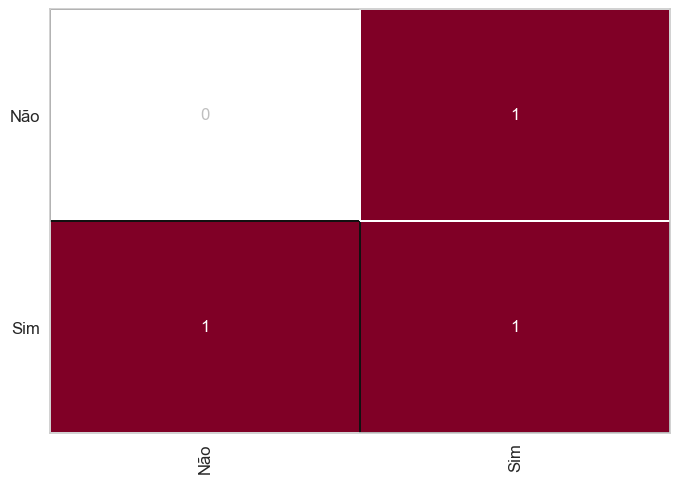

In [42]:
cm = ConfusionMatrix(model)
cm.fit(X_train.values, Y_train)
cm.score(X_test.values, Y_test)

In [43]:
print(classification_report(Y_test, test_predictions))

              precision    recall  f1-score   support

         Não       0.00      0.00      0.00         1
         Sim       0.50      0.50      0.50         2

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



### Plot da árvore

In [44]:
import matplotlib.pyplot as plt
from sklearn import tree

[Text(0.3333333333333333, 0.875, 'Hungry <= 0.5\nentropy = 0.991\nsamples = 9\nvalue = [5, 4]\nclass = Não'),
 Text(0.16666666666666666, 0.625, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = Não'),
 Text(0.5, 0.625, 'Italiano <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]\nclass = Sim'),
 Text(0.3333333333333333, 0.375, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = Sim'),
 Text(0.6666666666666666, 0.375, 'Client <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = Não'),
 Text(0.5, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Sim'),
 Text(0.8333333333333334, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Não')]

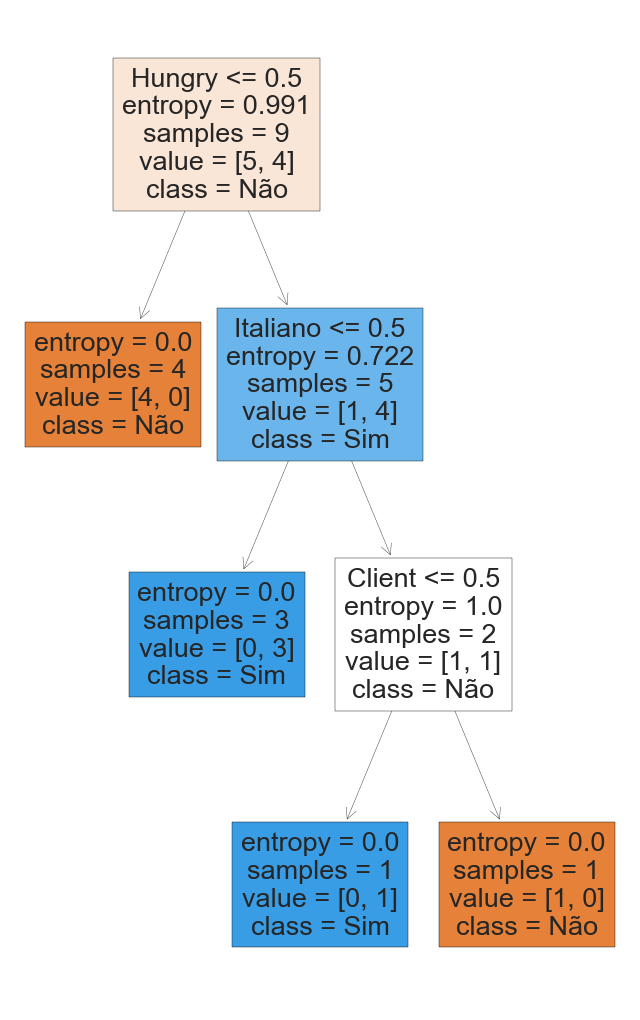

In [45]:
plt.subplots(nrows=1, ncols=1, figsize=(8, 13))
tree.plot_tree(
    model,
    feature_names=list(new_col_names),
    class_names=model.classes_.tolist(),
    filled=True,
)
